## Example. Probability of a girl birth given placenta previa

**Analysis using a uniform prior distribution**

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [3]:
births = 987
fem_births = 437

In [4]:
with pm.Model() as model_1:
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Binomial('observed', n=births, p=theta, observed=fem_births)

In [9]:
with model_1:
    trace_1 = pm.sample(draws=20_000, tune=50_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 280000/280000 [01:13<00:00, 3786.99draws/s]


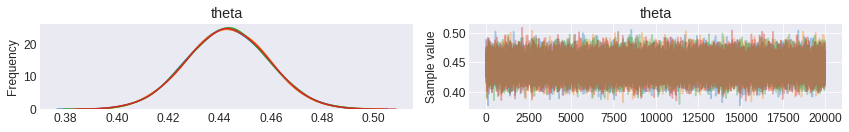

In [15]:
pm.traceplot(trace_1);

In [16]:
df = pm.summary(trace_1)
df.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.4429,0.0158,0.0001,0.4112,0.4732,36711.3548,1.0000


The summary shows the mean and the standard deviation, it also shows the 95% posterior interval [0.4112, 0.4732]. The next plot is the plot for the posterior distribution.

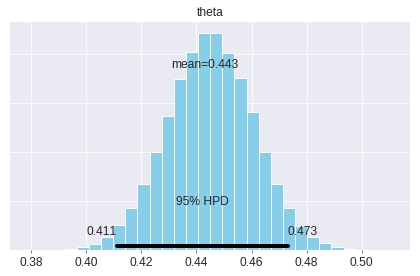

In [17]:
pm.plot_posterior(trace_1);

The true posterior distribution is $\textsf{Beta}(438, 544)$. Let's compare it with the one we found using `pymc3`.

In [18]:
from scipy.stats import beta

In [19]:
x = np.linspace(0, 1, 1000)
y = beta.pdf(x, 438, 544)

mean_t = df['mean'].values[0]
sd_t = df['sd'].values[0]
alpha_t = (mean_t**2 * (1 - mean_t)) / (sd_t**2) - mean_t
beta_t = (1 - mean_t) * (mean_t * (1 - mean_t) / sd_t**2 - 1)
y_pred = beta.pdf(x, alpha_t, beta_t)

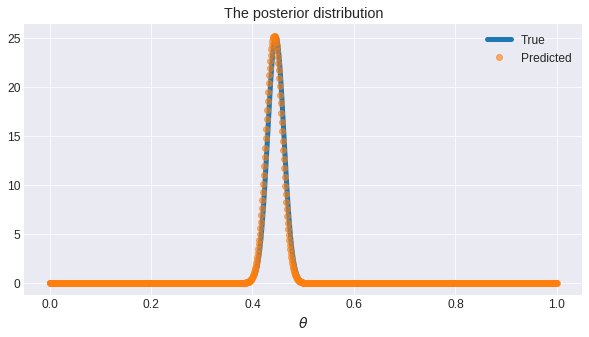

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', linewidth=4, alpha=0.6)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14)
plt.show()

Just like in the book, `phi` is the ratio of male to female births and `trans` is the logit transform of `theta`.

In [37]:
with pm.Model() as model_2:
    theta = pm.Uniform('theta', lower=0, upper=1)
    trans = pm.Deterministic('trans', pm.logit(theta))
    phi = pm.Deterministic('phi', (1 - theta) / theta)
    obs = pm.Binomial('observed', n=births, p=theta, observed=fem_births)

If you want to check if your model has no problems. Try to change the value for `observed` to a negative number to see what happens.

In [36]:
model_2.check_test_point()

theta_interval__    -1.39
observed           -10.15
Name: Log-probability of test_point, dtype: float64

In [29]:
with model_2:
    trace_2 = pm.sample(draws=5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:07<00:00, 3779.07draws/s]


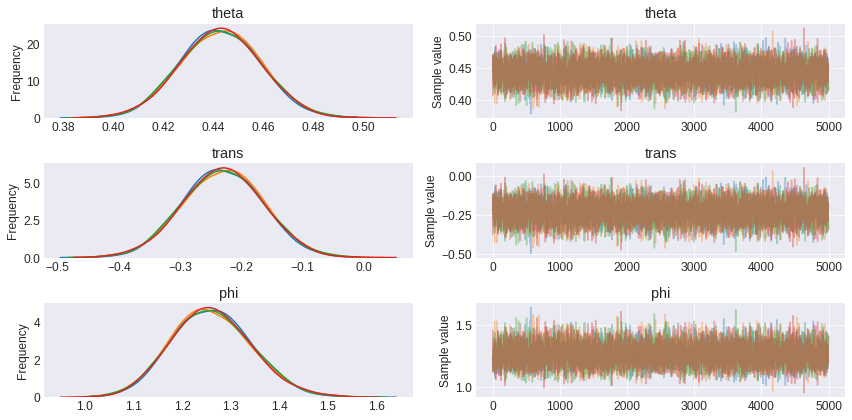

In [30]:
pm.traceplot(trace_2);

In [31]:
df2 = pm.summary(trace_2)
df2.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.4428,0.0159,0.0002,0.4118,0.4736,8383.7995,1.0000
trans,-0.2301,0.0646,0.0007,-0.3564,-0.1058,8386.2500,1.0000
phi,1.2613,0.0816,0.0008,1.1106,1.4270,8397.7695,1.0000


You can plot the posterior distribution for the logit transform, `trans`; the male-to-female sex ratio, `phi`.

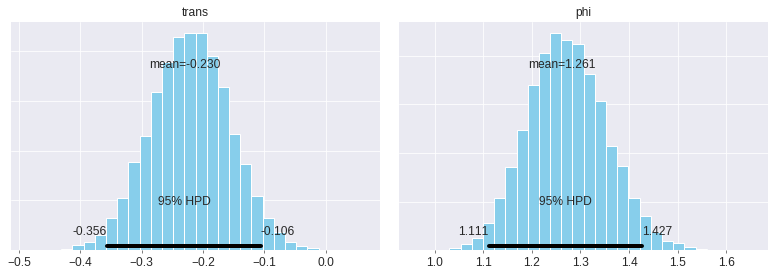

In [38]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(11, 4))
pm.plot_posterior(trace_2, varnames=['trans', 'phi'], ax=axes);

If you want the interval for `trans`, you have to invert the 95% interval on the logit scale

In [39]:
lldd = pm.invlogit(df2.loc['trans','hpd_2.5']).eval()
llii = pm.invlogit(df2.loc['trans','hpd_97.5']).eval()

print('The interval is [{:.3f}, {:.3f}]'.format(lldd, llii))

The interval is [0.412, 0.474]


**Analysis using a nonconjugate prior distribution**

And with a custom prior distribution, a triangular one with a uniform distribution to the left and a uniform distribution to the right.

In [59]:
import theano.tensor as tt

def triangular(central_num, width):
    
    left_num = central_num - width
    right_num = central_num + width
    theta = pm.Triangular('theta', lower=left_num, upper=right_num, c=central_num)
    
#     Comment these lines to see some changes
    if tt.lt(left_num, theta):
        theta = pm.Uniform('theta1', lower=0, upper=left_num)
    if tt.gt(right_num, theta):
        theta = pm.Uniform('theta2', lower=right_num, upper=1)
        
    return theta 

Remember, you can play with `width`. In this case, `width=0.09`

In [60]:
central_num = 0.485
width = 0.09

with pm.Model() as model_3:
    theta = triangular(central_num, width)
    obs = pm.Binomial('observado', n=births, p=theta, observed=fem_births)

In [65]:
with model_3:
    trace_3 = pm.sample(draws=10_000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1, theta]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:35<00:00, 2239.60draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


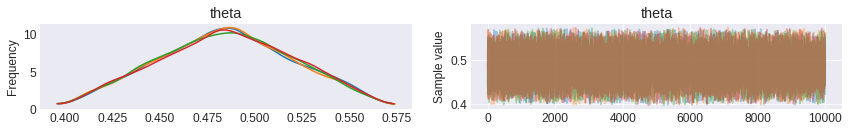

In [69]:
pm.traceplot(trace_3, varnames=['theta']);

In [67]:
df3 = pm.summary(trace_3, varnames=['theta'])
df3.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.4848,0.0366,0.0002,0.4143,0.5533,28050.7879,1.0000


And the posterior distribution for `theta` is this.

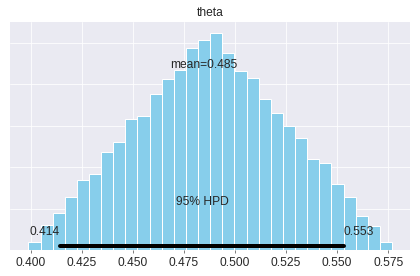

In [68]:
pm.plot_posterior(trace_3, varnames=['theta']);

## Estimating a rate from Poisson data: an idealized example

In [70]:
with pm.Model() as poisson_model:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=2 * theta, observed=3)

In [71]:
poisson_model.check_test_point()

theta_log__   -0.40
post          -2.44
Name: Log-probability of test_point, dtype: float64

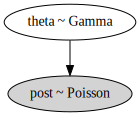

In [72]:
pm.model_to_graphviz(poisson_model)

In [80]:
with poisson_model:
    trace_poisson = pm.sample(draws=10_000, tune=10_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 80000/80000 [00:22<00:00, 3618.87draws/s]


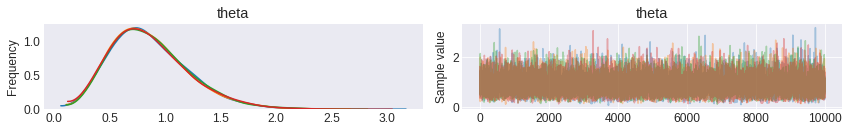

In [78]:
pm.traceplot(trace_poisson);

In [79]:
df4 = pm.summary(trace_poisson)
df4.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.8562,0.3505,0.0025,0.2495,1.5491,18240.0849,1.0000


The plot of the posterior distribution

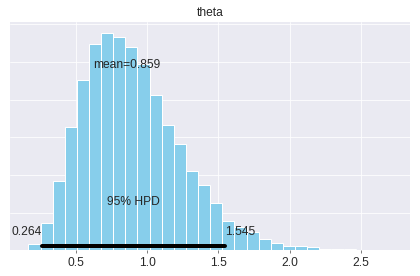

In [76]:
pm.plot_posterior(trace_poisson);

The true posterior distribution is $\textsf{Gamma}(6,7)$. Let's compare it with the one we found using `pymc3`.

In [81]:
from scipy.stats import gamma

In [82]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 6, scale=1/7)

mean_t = df4['mean'].values[0]
sd_t = df4['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

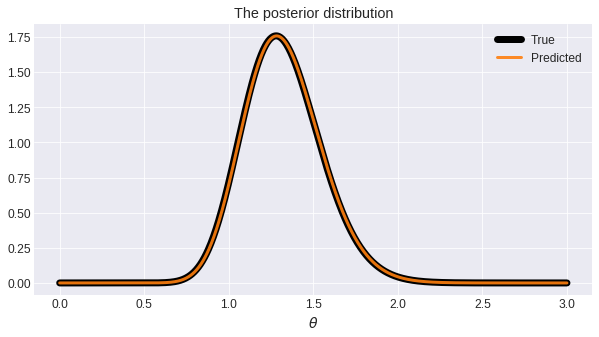

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=7)
plt.plot(x, y_pred, 'C1', label='Predicted', linewidth=3, alpha=0.9)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14)
plt.show()

If we add additional data, `mu` in `post` changes

In [87]:
with pm.Model() as poisson_model_2:
    theta = pm.Gamma('theta', alpha=3, beta=5)
    post = pm.Poisson('post', mu=20 * theta, observed=30)

In [121]:
with poisson_model_2:
    trace_poisson_2 = pm.sample(draws=10_000, tune=15_000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:26<00:00, 3766.77draws/s]


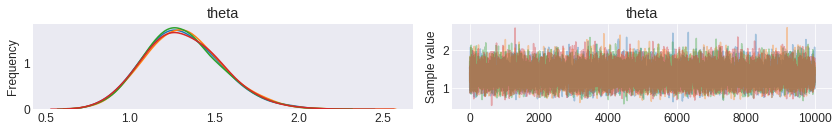

In [122]:
pm.traceplot(trace_poisson_2);

In [123]:
df5 = pm.summary(trace_poisson_2)
df5.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,1.3185,0.2307,0.0018,0.8955,1.7946,17915.6271,1.0002


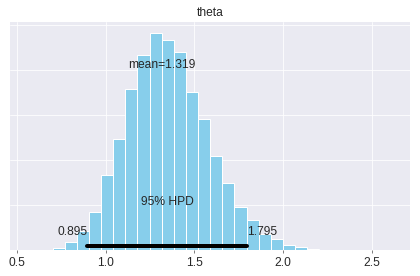

In [124]:
pm.plot_posterior(trace_poisson_2);

The true posterior distribution is $\textsf{Gamma}(33, 25)$

In [103]:
x = np.linspace(0, 3, 1000)
y = gamma.pdf(x, 33, scale=1/25) # How you write alpha and beta

mean_t = df5['mean'].values[0]
sd_t = df5['sd'].values[0]
alpha_t = mean_t**2 / sd_t**2
beta_t = mean_t / sd_t**2
y_pred = gamma.pdf(x, alpha_t, scale=1/beta_t)

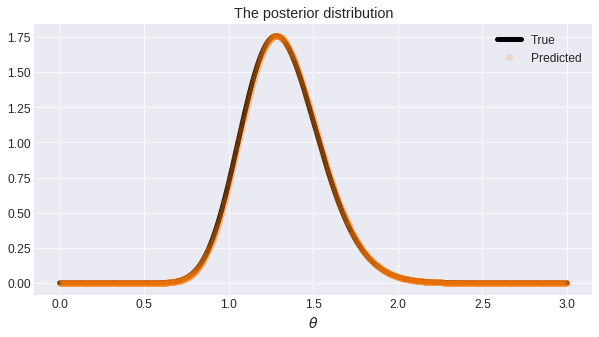

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'k', label='True', linewidth=5)
plt.plot(x, y_pred, 'oC1', label='Predicted', alpha=0.15)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\theta$', fontsize=14)
plt.show()

In [97]:
val = np.mean(trace_poisson_2['theta'] >= 1)
print(f'The posterior probability that theta exceeds 1.0 is {val:.2f}.')

The posterior probability that theta exceeds 1.0 is 0.93.


In [98]:
%load_ext watermark

In [102]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.15.0
pymc3       3.5
CPython 3.6.6
IPython 7.1.1

theano 1.0.2
scipy 1.1.0
matplotlib 2.2.3

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-138-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
